In [164]:
import os 
import time 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import  metrics
import gensim
import re

In [2]:
import torch 
import torch.nn as nn
import tensorflow as tf
from torch.utils.data import DataLoader, Dataset

torch.manual_seed(42);
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print('Device : ', device)

Device :  cpu


## Data Wrangling

In [10]:
df_pos = pd.read_csv('../input/arabic-sentiment-twitter-corpus/train_Arabic_tweets_positive_20190413.tsv', sep= '\t', header= None, names = ['label','tweet'])
df_neg = pd.read_csv('../input/arabic-sentiment-twitter-corpus/train_Arabic_tweets_negative_20190413.tsv', sep= '\t', header= None, names = ['label','tweet'])

In [14]:
df_pos.head()  

,label,tweet
0,pos,نحن الذين يتحول كل ما نود أن نقوله إلى دعاء لل...
1,pos,وفي النهاية لن يبقىٰ معك آحدإلا من رأىٰ الجمال...
2,pos,من الخير نفسه 💛
3,pos,#زلزل_الملعب_نصرنا_بيلعب كن عالي الهمه ولا ترض...
4,pos,الشيء الوحيد الذي وصلوا فيه للعالمية هو : المس...


In [12]:
df_neg.head()

,label,tweet
0,neg,اعترف ان بتس كانو شوي شوي يجيبو راسي لكن اليوم...
1,neg,توقعت اذا جات داريا بشوفهم كاملين بس لي للحين ...
2,neg,#الاهلي_الهلال اكتب توقعك لنتيجة لقاء الهلال و...
3,neg,نعمة المضادات الحيوية . تضع قطرة💧مضاد بنسلين ع...
4,neg,الدودو جايه تكمل علي 💔


In [47]:
##-- concat and shuffle
df_train = pd.concat([df_pos,df_neg],axis = 0).sample(frac = 1.0)

In [52]:
df_train['target'] = df_train['label'].map({'pos':1,'neg':0},)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45275 entries, 19317 to 11681
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   45275 non-null  object
 1   tweet   45275 non-null  object
 2   target  45275 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [55]:
#-- no nulls
df_train.isna().sum()

label     0
tweet     0
target    0
dtype: int64

In [56]:
#-- ~ balanced target
df_train['target'].value_counts()

1    22761
0    22514
Name: target, dtype: int64

## Tokenization

In [62]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df_train['tweet'].values.tolist())

In [63]:
#--- view number of documents
print('n of documents: ' , tokenizer.document_count)

#--- view tokens
for i in tokenizer.index_word.keys():
    index = i
    word = tokenizer.index_word[i]
    frequency = tokenizer.word_counts[word]
    print( 'Index : ', i,', word : ', word  , ', Frequency : ', frequency)
    if i > 5:
        break

n of documents:  45275
Index :  1 , word :  من , Frequency :  10435
Index :  2 , word :  في , Frequency :  7564
Index :  3 , word :  الله , Frequency :  6671
Index :  4 , word :  و , Frequency :  5357
Index :  5 , word :  على , Frequency :  5027
Index :  6 , word :  💔 , Frequency :  4909


**Text Data to padded sequences**

In [90]:
#-- tweet statistics
df_train['tweet_length'] = df_train['tweet'].str.len()
df_train.groupby('label',axis=0).agg({'tweet_length':  ['min','mean','median','max','count']})

tweet_length                               
               min       mean median   max  count
label                                            
neg              5  63.854579   58.0  5943  22514
pos              6  71.446729   68.0  8109  22761

In [91]:
MAX_LENGTH = 128
reviews_sequences = tokenizer.texts_to_sequences(df_train['tweet'].values)
reviews_padded = tf.keras.preprocessing.sequence.pad_sequences(reviews_sequences, maxlen=MAX_LENGTH )

In [96]:
reviews_padded[911]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,    52,    52,    52,    52,    52,    52,    52,    10,
           3,    13,    10, 36897, 36898,   370,  9936,   132,  1149,
       36899, 36900, 18988,    52,    52,    52,    52,    52,    52,
          52,    52]

In [98]:
#-- train, validation split
X_train, X_valid, y_train, y_valid = train_test_split(np.array(reviews_padded), df_train['target'].values, stratify = df_train['target'].values, test_size=0.15, random_state=42)

In [100]:
#-- split count
'Train: ', X_train.shape ,y_train.shape,' |Test: ', X_valid.shape ,y_valid.shape

('Train: ', (38483, 128), (38483,), ' |Test: ', (6792, 128), (6792,))

In [101]:
#-- labels balance
y_train.sum() / len(y_train) , y_valid.sum() / len(y_valid) 

(0.5027154847595042, 0.5027974087161367)

## Build Datset & Dataloader

In [110]:
class TwitterDataset(Dataset):
    def __init__(self, tweets, targets):
        super(TwitterDataset, self).__init__()
        self.tweets = tweets
        self.targets = targets
        
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, index):
        tweet = self.tweets[index, :]
        target = self.targets[index]
        
        return tweet, target

**Data Loader**

In [111]:
BATCH_SIZE = 64

##-- Train
train_dataset = TwitterDataset(tweets = X_train ,targets = y_train)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)

##-- Validation
valid_dataset = TwitterDataset(tweets = X_valid ,targets = y_valid)
valid_loader = DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [108]:
len(train_loader), len(valid_loader)

(602, 107)

In [113]:
#-- sanity check
for (tweet, target) in train_loader:
    print(tweet[0], target[0])
    break

tensor([    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,    48,
        53343,  2994,  3154,     6,   916,  6133,   906,  7343],

## Word Embeddings

In [118]:
#-- using AraVec https://github.com/bakrianoo/aravec 
#-- using AraVec 1.0 for fast download
!wget https://www.dropbox.com/s/ce9phmmawoe1ure/Twt-CBOW.zip?dl=0

--2021-12-13 19:24:10--  https://www.dropbox.com/s/ce9phmmawoe1ure/Twt-CBOW.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.18, 2620:100:601f:18::a27d:912
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ce9phmmawoe1ure/Twt-CBOW.zip [following]
--2021-12-13 19:24:11--  https://www.dropbox.com/s/raw/ce9phmmawoe1ure/Twt-CBOW.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc882c0656feeca1e0ef858cdfa9.dl.dropboxusercontent.com/cd/0/inline/Bbz_ftFdZBFA9rUm62pWwoT0euU7KCKRxTSrEWWXxYNWH5rYNAS40RlL3pQYCZ9Sg24Cg4WR_eYu17hdQ8FHcfBuVPc6yLMBG1Mqs4x1UzNigxcSnEcdreyjrDRZ3u2hSNosDdI6Gqn93p2mHsN1-Oty/file# [following]
--2021-12-13 19:24:12--  https://uc882c0656feeca1e0ef858cdfa9.dl.dropboxusercontent.com/cd/0/inline/Bbz_ftFdZBFA9rUm62pWwoT0euU7KCKRxTSrEWWXxYNWH5rYNAS40RlL3pQYCZ9Sg24Cg4WR_eYu17hdQ8FHc

In [120]:
!unzip './Twt-CBOW.zip?dl=0' 

Archive:  ./Twt-CBOW.zip?dl=0
  inflating: Twt-CBOW                
  inflating: Twt-CBOW.syn1neg.npy    
  inflating: Twt-CBOW.wv.syn0.npy    


In [121]:
# load the model
model = gensim.models.Word2Vec.load('Twt-CBOW')

## Build Embedding matrix

In [147]:
def build_embedding_matrix_gensim_model(word_index, pretrained_embedding, embedding_dimension = 300):
    utilized_from_embedding = 0
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dimension)) #-- + 1 for padding?
    
    for index, word in enumerate(word_index.keys()):
        if pretrained_embedding.wv.has_index_for(word) : 
            embedding_matrix[index] = pretrained_embedding.wv[word]
            utilized_from_embedding += 1
            
    print(f'Utilized from Pretrained Embedding : {utilized_from_embedding/len(word_index):0.02f} %')
    return embedding_matrix

In [149]:
embedding_matrix = build_embedding_matrix_gensim_model(tokenizer.word_index,model,300)
embedding_matrix.shape

Utilized from Pretrained Embedding : 0.50 %


(78652, 300)

## Model Building

In [150]:
class LSTM(nn.Module):
    def __init__(self, embedding_matrix):
        super(LSTM, self).__init__()
        vocab_size = embedding_matrix.shape[0]
        embedding_dim = embedding_matrix.shape[1]
        
        self.embedding = nn.Embedding(num_embeddings = vocab_size, embedding_dim = embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False #-- don't train
        
        self.lstm = nn.LSTM(embedding_dim, 128, bidirectional=True, batch_first=True)
        
        self.out = nn.Linear(512,1)
        
    def forward(self, x):
        x = self.embedding(x)
        
        hidden, _ = self.lstm(x)
        
        avg_pool = torch.mean(hidden,1)
        max_pool,_ = torch.max(hidden,1)
        
        out = torch.cat((avg_pool, max_pool), 1)
        out = self.out(out)
        return out

In [151]:
model = LSTM(embedding_matrix).to(device)

In [152]:
##-- model check
for tweet,target in train_loader:
    print(model(tweet.to(device))[0])
    break

tensor([-0.4108], grad_fn=<SelectBackward>)


## Training & Evaluation

In [154]:
optimizer = torch.optim.Adam(model.parameters(), lr= 1e-4)
criterion = nn.BCEWithLogitsLoss()

In [153]:
def train(model, dataloader):
    model.train()
    
    for reviews, labels in dataloader:
        reviews = reviews.to(device, dtype=torch.long)
        labels  = labels.to(device, dtype=torch.float)
        
        predictions = model(reviews)
        
        loss = criterion(predictions, labels.view(-1,1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [155]:
def evaluate(model, dataloader):
    model.eval()
    
    targets = []
    model_predictions = []
    with torch.no_grad():
        for reviews, labels in dataloader:

            reviews = reviews.to(device, dtype=torch.long)
            predictions = model(reviews).cpu().numpy().tolist()
            
            model_predictions.extend(predictions)
            
            labels  = labels.cpu().numpy().tolist()
            targets.extend(labels)
           
    return model_predictions, targets

In [195]:
MAX_EPOCHS = 5
for epoch in range(MAX_EPOCHS):
        train(model, train_loader) 
        model_predictions, targets = evaluate(model, valid_loader)
        
        outputs = np.array(model_predictions) >= 0.5

        accuracy = metrics.accuracy_score(targets, outputs)
        print(f'epoch: {epoch}, accuracy_score: {accuracy}')

epoch: 0, accuracy_score: 0.8471731448763251
epoch: 1, accuracy_score: 0.8274440518256773
epoch: 2, accuracy_score: 0.8530624263839811
epoch: 3, accuracy_score: 0.8228798586572438
epoch: 4, accuracy_score: 0.8671967020023557


In [205]:
def infer(sentence):
    model.eval()
    sentence = np.array([sentence])
    sentence_tokens = tokenizer.texts_to_sequences(sentence)
    sentence_tokens = tf.keras.preprocessing.sequence.pad_sequences(sentence_tokens, maxlen = MAX_LENGTH)
    sentence_tensor = torch.tensor(sentence_tokens, dtype = torch.long).to(device, dtype = torch.long)
    
    output = model(sentence_tensor)
    if output.item() > 0.5:
        print('Positive', output.item())
    else:
        print('Negative', output.item())

In [216]:
infer('لا احب هذا الشيء لانه سيء')

Negative 0.12843497097492218


In [221]:
infer('احب هذا الشيء هو ليس سيء')

Positive 0.8019070625305176


## Test

In [165]:
df_test_pos = pd.read_csv('../input/arabic-sentiment-twitter-corpus/test_Arabic_tweets_positive_20190413.tsv', sep= '\t', header= None, names = ['label','tweet'])
df_test_neg = pd.read_csv('../input/arabic-sentiment-twitter-corpus/test_Arabic_tweets_negative_20190413.tsv', sep= '\t', header= None, names = ['label','tweet'])

In [166]:
##-- concat and shuffle
df_test = pd.concat([df_test_pos,df_test_neg],axis = 0).sample(frac = 1.0)
df_test['target'] = df_test['label'].map({'pos':1,'neg':0},)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11520 entries, 4537 to 2770
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   11520 non-null  object
 1   tweet   11520 non-null  object
 2   target  11520 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 360.0+ KB


In [167]:
reviews_sequences_test = tokenizer.texts_to_sequences(df_test['tweet'].values)
reviews_padded_test = tf.keras.preprocessing.sequence.pad_sequences(reviews_sequences_test, maxlen=MAX_LENGTH)

In [169]:
type(reviews_padded_test)

numpy.ndarray

In [171]:
##-- Test
test_dataset = TwitterDataset(tweets = reviews_padded_test ,targets = df_test['target'].values)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [196]:
model_predictions, targets = evaluate(model, test_loader)
        
outputs = np.array(model_predictions) >= 0.5

print(f'Test Accuracy Score: {metrics.accuracy_score(targets, outputs)}')
print(metrics.classification_report(targets, outputs))

Test Accuracy Score: 0.9152777777777777
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      5768
           1       0.93      0.90      0.91      5752

    accuracy                           0.92     11520
   macro avg       0.92      0.92      0.92     11520
weighted avg       0.92      0.92      0.92     11520



<AxesSubplot:>

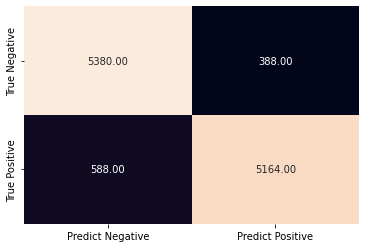

In [197]:
sns.heatmap(metrics.confusion_matrix(targets, outputs), annot=True ,fmt='.2f', cbar=False , yticklabels=['True Negative','True Positive'], xticklabels=['Predict Negative','Predict Positive'])

---

# What's Next, (Improvements)
    * Enhance the text preprocessing, for example removing stopwords.
    * Add more layers and increase model capacity, we only used one bidirectional lstm.
    * More training iterations, we only trained for 5 epochs.